# **Forecasting Model**

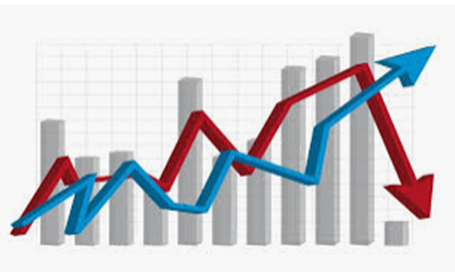

**Context**:

Dataset contains the demand shipment history of product at a store for multiple customers from global sites for the past two years.

**Objective**:

Find a best forecast model to predict product shipment demands for future with the given retailer data.

## **1. Import Python Libraries**

In [1]:
#Load ML libraries
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#Load DL libraries
import keras
import sys
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
import lightgbm as lgb

from keras.preprocessing.sequence import TimeseriesGenerator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retailer-data/0029977001001UA096_ST10.csv


## **2. Load Dataset using Pandas**

In [2]:
retail_club = pd.read_csv('/kaggle/input/retailer-data/0029977001001UA096_ST10.csv')
retail_club.head()

,DmdUnit,DmdGroup,Loc,StartDate,Type - 1,Type - 2,Type - 2 DNR,Week,Base
0,0029977001001UA096,RETAIL,ST00010UA096,8-Apr-18,900.63,-118.185,NaN,1,1018.815
1,0029977001001UA097,RETAIL,ST00010UA097,15-Apr-18,838.77,-180.045,NaN,2,1018.815
2,0029977001001UA098,RETAIL,ST00010UA098,22-Apr-18,699.55,-319.265,NaN,3,1018.815
3,0029977001001UA099,RETAIL,ST00010UA099,29-Apr-18,872.28,-146.535,NaN,4,1018.815
4,0029977001001UA100,RETAIL,ST00010UA100,6-May-18,NaN,-1018.815,NaN,5,1018.815


In [3]:
print(retail_club.iloc[0])

DmdUnit         0029977001001UA096
DmdGroup                    RETAIL
Loc                   ST00010UA096
StartDate                 8-Apr-18
Type - 1                    900.63
Type - 2                  -118.185
Type - 2 DNR                   NaN
Week                             1
Base                       1018.82
Name: 0, dtype: object


In [4]:
print(retail_club.iloc[114])

DmdUnit         0029977001001UA210
DmdGroup                    RETAIL
Loc                   ST00010UA210
StartDate                14-Jun-20
Type - 1                    589.94
Type - 2                  -127.565
Type - 2 DNR                  8.68
Week                           115
Base                       708.825
Name: 114, dtype: object


## **3. Data Slicing**

In [5]:
retail_df = retail_club.iloc[0:115]
print('First date record of retail data: \n', retail_df.head(1).StartDate)
print('\n')
print('Last date record of retail data: \n',retail_df.tail(1).StartDate)

First date record of retail data: 
 0    8-Apr-18
Name: StartDate, dtype: object


Last date record of retail data: 
 114    14-Jun-20
Name: StartDate, dtype: object


## **4. Feature Engineering (using todatetime)**

In [6]:
#Transform string to date
retail_df['StartDate'] = pd.to_datetime(retail_df.StartDate, format="%d-%b-%y")

#Extracting Year
retail_df['Year'] = retail_df['StartDate'].dt.year

## **5. Plot Historical Data**

[Text(0.5, 1.0, 'Quarterly Sales')]

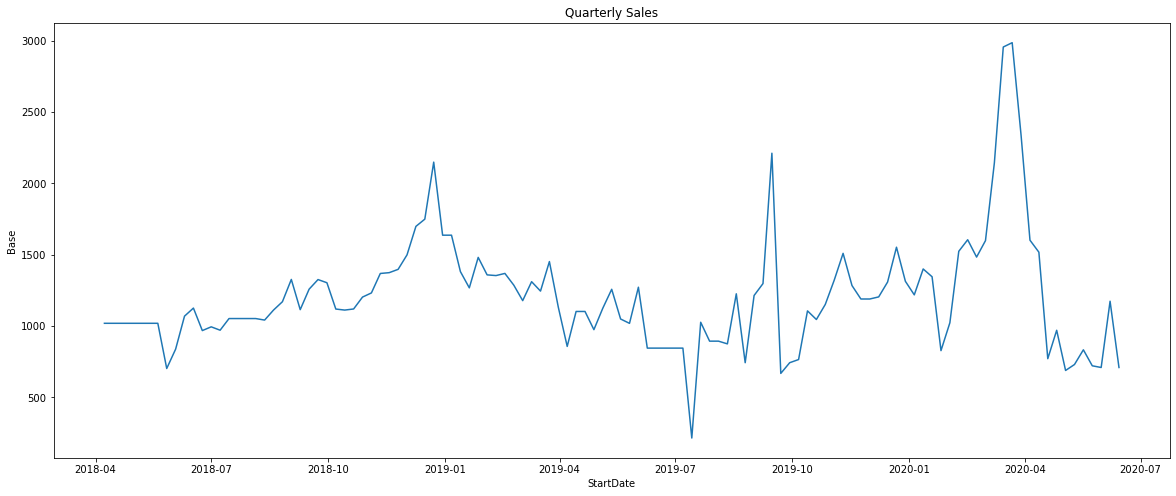

In [7]:
f, ax = plt.subplots(1,1, figsize=(20,8))
plot = sns.lineplot(x='StartDate', y='Base', data=retail_df)
plot.set(title='Quarterly Sales')

In [8]:
retail_df.corr()

,Type - 1,Type - 2,Type - 2 DNR,Week,Base,Year
Type - 1,1.000000,0.669041,0.915777,0.197984,0.932934,0.159061
Type - 2,0.669041,1.000000,1.000000,-0.125388,0.283040,-0.205322
Type - 2 DNR,0.915777,1.000000,1.000000,-0.111875,0.846752,NaN
Week,0.197984,-0.125388,-0.111875,1.000000,0.139414,0.925442
Base,0.932934,0.283040,0.846752,0.139414,1.000000,0.136982
Year,0.159061,-0.205322,NaN,0.925442,0.136982,1.000000


In [9]:
retail_data = retail_df[["StartDate", "Type - 1", "Type - 2 DNR", "Base"]]
retail_data.shape

(115, 4)

## **6. Find missing data and Handling Null/NaN values**

In [10]:
retail_data.isnull().sum()

StartDate         0
Type - 1          7
Type - 2 DNR    110
Base              0
dtype: int64

**Inference**: Type - 1 and Type - 2 DNR carries Null values and need to be handled.

**Handling Missing Data (Using KNN Imputation Method)**

In [11]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
retail_data_imputation = imputer.fit_transform(retail_data.drop(columns=["StartDate"]))
retail_imputed_df = pd.DataFrame(data=retail_data_imputation, columns=["Type - 1", "Type - 2 DNR",	"Base"])
#retail_impute_df["Week"] = retail_impute_df["Week"].astype('int64')
retail_imputed_df.head()

,Type - 1,Type - 2 DNR,Base
0,900.63,15.105,1018.815
1,838.77,13.085,1018.815
2,699.55,13.085,1018.815
3,872.28,13.085,1018.815
4,869.70,15.105,1018.815


In [12]:
print('After Imputation: \n')
print(retail_imputed_df.isnull().sum(), '\n')

After Imputation: 

Type - 1        0
Type - 2 DNR    0
Base            0
dtype: int64 



## **7. Descriptive Statistics**

In [13]:
retail_imputed_df.describe()

,Type - 1,Type - 2 DNR,Base
count,115.000000,115.000000,115.000000
mean,1130.682348,14.185435,1204.839348
std,455.345433,1.773851,405.337671
min,176.780000,8.680000,213.990000
25%,850.765000,13.085000,1006.225000
50%,1119.270000,15.105000,1131.815000
75%,1333.300000,15.105000,1349.405000
max,2987.170000,18.210000,2987.170000


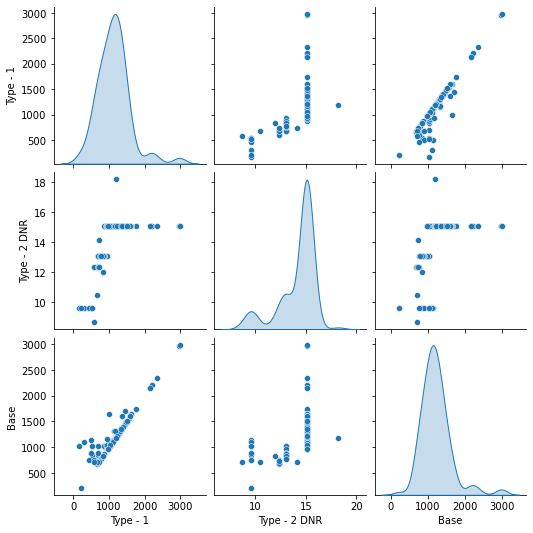

In [14]:
sns.pairplot(retail_imputed_df, diag_kind='kde')

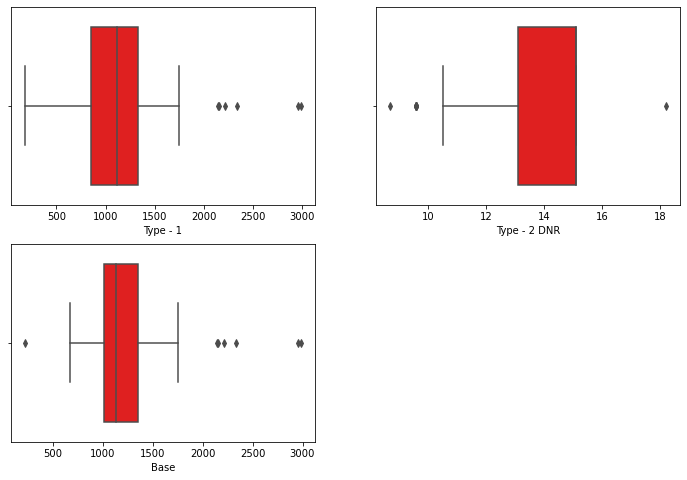

In [15]:
## Univariate Analysis using boxplot
## Checking the presence of outliers
pos = 1
plt.figure(figsize=(12,8))
for i in retail_imputed_df.columns:
    plt.subplot(2, 2, pos)
    sns.boxplot(retail_imputed_df[i],color="red")
    pos += 1

**Inference**: All columns have outliers.

## **8. Detection and Handle Outliers**

**Using z-score**

In [16]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(retail_imputed_df))
print('Z-score of column values:\n', z)

Z-score of column values:
 [[5.07437056e-01 5.20669186e-01 4.60945222e-01]
 [6.43884506e-01 6.23079768e-01 4.60945222e-01]
 [9.50968471e-01 6.23079768e-01 4.60945222e-01]
 [5.69969957e-01 6.23079768e-01 4.60945222e-01]
 [5.75660781e-01 5.20669186e-01 4.60945222e-01]
 [2.10406633e+00 2.60199194e+00 4.60945222e-01]
 [1.30737292e+00 2.60199194e+00 4.60945222e-01]
 [9.46115829e-01 1.04773903e+00 1.24659290e+00]
 [6.46729919e-01 6.23079768e-01 9.10270823e-01]
 [1.35989422e-01 5.20669186e-01 3.36518691e-01]
 [1.13427134e-02 5.20669186e-01 1.96493932e-01]
 [4.18082284e-01 6.23079768e-01 5.87595647e-01]
 [3.01464491e-01 5.20669186e-01 5.22408930e-01]
 [3.53784787e-01 5.20669186e-01 5.81184143e-01]
 [4.09126955e-01 5.20669186e-01 3.78462933e-01]
 [4.93187937e-01 5.20669186e-01 3.78462933e-01]
 [3.98737891e-01 5.20669186e-01 3.78462933e-01]
 [2.42460784e-01 5.20669186e-01 3.78462933e-01]
 [1.96956243e-01 5.20669186e-01 4.05007177e-01]
 [6.79642143e-02 5.20669186e-01 2.31134635e-01]
 [8.69453304e

In [17]:
# Setting threshold to identify an outlier
threshold = 3
print(np.where(z > 3))

(array([101, 101, 102, 102, 114]), array([0, 2, 0, 2, 1]))


**Outliers**: First array contains the list of row numbers, second array are respective column numbers and each outlier have a Z-Score higher than 3.

In [18]:
print('Below are outliers in retail data: \n')
z[101][0], z[101][2], z[102][0], z[102][2], z[114][1]

Below are outliers in retail data: 



(4.027973844792241,
 4.341165608176481,
 4.094940294690917,
 4.416393916196766,
 3.1172451846021274)

In [19]:
print('Shape of retail data with outliers:', retail_imputed_df.shape)
retail_z_nonout = retail_imputed_df[(z < 3).all(axis=1)]
print('Shape of retail data after removing outliers using z-score:', retail_z_nonout.shape)
retail_z_nonout.info()

Shape of retail data with outliers: (115, 3)
Shape of retail data after removing outliers using z-score: (112, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 0 to 113
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Type - 1      112 non-null    float64
 1   Type - 2 DNR  112 non-null    float64
 2   Base          112 non-null    float64
dtypes: float64(3)
memory usage: 3.5 KB


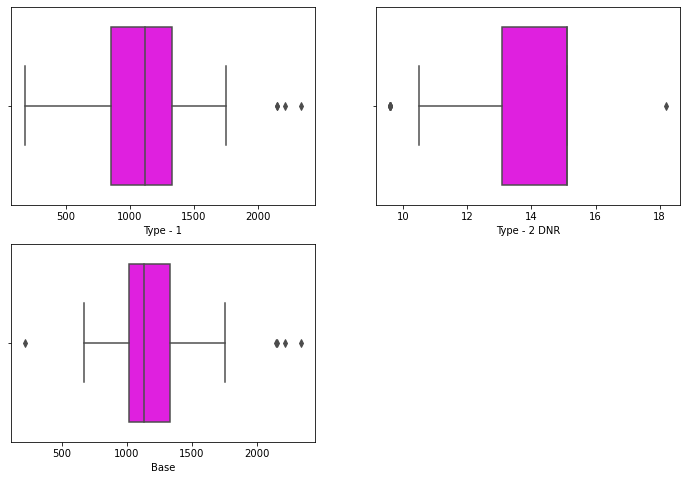

In [20]:
pos = 1
plt.figure(figsize=(12,8))
for i in retail_z_nonout.columns:
    plt.subplot(2, 2, pos)
    sns.boxplot(retail_z_nonout[i],color="magenta")
    pos += 1

**Inference**: Still outliers exists in dataset. Hence proceeding with IQR way of method.

**Using IQR Method:**

In [21]:
## Detect outliers using IQR and Handling outliers
Q1 = retail_z_nonout.quantile(0.25)
Q3 = retail_z_nonout.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Type - 1        472.1225
Type - 2 DNR      2.0200
Base            318.8200
dtype: float64


In [22]:
## Checking for outliers presence of data points with "True"
bool_outs= (retail_z_nonout < (Q1 - 1.5 * IQR)) |(retail_z_nonout > (Q3 + 1.5 * IQR))
print(bool_outs)

     Type - 1  Type - 2 DNR   Base
0       False         False  False
1       False         False  False
2       False         False  False
3       False         False  False
4       False         False  False
..        ...           ...    ...
109     False         False  False
110     False         False  False
111     False         False  False
112     False         False  False
113     False          True  False

[112 rows x 3 columns]


In [23]:
## Removing outliers from dataframe
retail_final = retail_z_nonout[~bool_outs.any(axis=1)]
print('Shape of dataframe with outliers: {}'.format(retail_z_nonout.shape))
print('Shape of dataframe without outliers: {}'.format(retail_final.shape))

Shape of dataframe with outliers: (112, 3)
Shape of dataframe without outliers: (98, 3)


In [24]:
# Checking correlation to remove unnecessary columns from dataset
retail_final.corr()

,Type - 1,Type - 2 DNR,Base
Type - 1,1.000000,0.727310,0.938245
Type - 2 DNR,0.727310,1.000000,0.712326
Base,0.938245,0.712326,1.000000


**Inference**:
Base is highly correlated with Type - 1 and is less correlated with Type - 2 DNR. Hence removing Type - 2 DNR from dataset.

In [25]:
retail_model = retail_final[["Type - 1", "Base"]]
retail_model.head()

,Type - 1,Base
0,900.63,1018.815
1,838.77,1018.815
2,699.55,1018.815
3,872.28,1018.815
4,869.70,1018.815


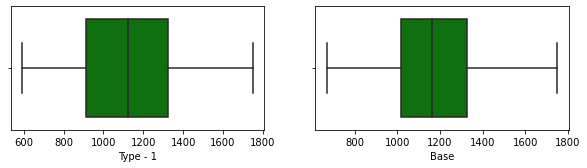

In [26]:
pos = 1
plt.figure(figsize=(10,5))
for i in retail_model.columns:
    plt.subplot(2, 2, pos)
    sns.boxplot(retail_model[i],color="green")
    pos += 1

## **9. Feature Engineering (Using rolling window calculations)**

In [27]:
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    retail_model[lag_i] = retail_model.Base.shift(i)
    
# Rolling window
retail_model['rolling_mean'] = retail_model.Base.rolling(window=2).mean()
retail_model['rolling_max'] = retail_model.Base.rolling(window=2).max()
retail_model['rolling_min'] = retail_model.Base.rolling(window=2).min()

## **10. Correlation of features**

<AxesSubplot:>

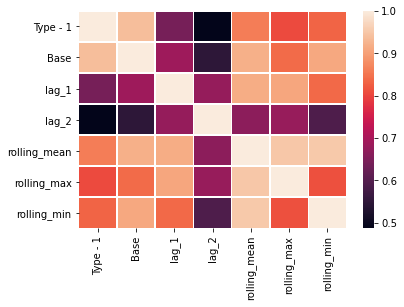

In [28]:
# Correlation matrix with heatmap
corr = retail_model.corr()
fig = plt.figure(figsize=(6,4))
sns.heatmap(corr, linewidths=.5)

In [29]:
retail_model.corr()

,Type - 1,Base,lag_1,lag_2,rolling_mean,rolling_max,rolling_min
Type - 1,1.000000,0.938245,0.642770,0.487082,0.861298,0.806927,0.833082
Base,0.938245,1.000000,0.689437,0.548426,0.920328,0.840544,0.911638
lag_1,0.642770,0.689437,1.000000,0.679040,0.917834,0.909206,0.838971
lag_2,0.487082,0.548426,0.679040,1.000000,0.667443,0.680453,0.591422
rolling_mean,0.861298,0.920328,0.917834,0.667443,1.000000,0.951617,0.952652
rolling_max,0.806927,0.840544,0.909206,0.680453,0.951617,1.000000,0.813125
rolling_min,0.833082,0.911638,0.838971,0.591422,0.952652,0.813125,1.000000


**Inference**: Base is less correlated with lag_1 and lag_2. Hence removing them from dataset.

In [30]:
retail_model_final = retail_model[["Type - 1", "rolling_mean",	"rolling_max", "rolling_min", "Base"]]
print('Shape:', retail_model_final.shape)
retail_model_final.head()

Shape: (98, 5)


,Type - 1,rolling_mean,rolling_max,rolling_min,Base
0,900.63,NaN,NaN,NaN,1018.815
1,838.77,1018.815,1018.815,1018.815,1018.815
2,699.55,1018.815,1018.815,1018.815,1018.815
3,872.28,1018.815,1018.815,1018.815,1018.815
4,869.70,1018.815,1018.815,1018.815,1018.815


**Fill NaN with Mean values**

In [31]:
retail_model_final.mean()

Type - 1        1119.488061
rolling_mean    1165.299845
rolling_max     1232.056701
rolling_min     1098.542990
Base            1162.223520
dtype: float64

In [32]:
retail_model_final.fillna(retail_model_final.mean(), inplace = True)
retail_model_final.head()

,Type - 1,rolling_mean,rolling_max,rolling_min,Base
0,900.63,1165.299845,1232.056701,1098.54299,1018.815
1,838.77,1018.815000,1018.815000,1018.81500,1018.815
2,699.55,1018.815000,1018.815000,1018.81500,1018.815
3,872.28,1018.815000,1018.815000,1018.81500,1018.815
4,869.70,1018.815000,1018.815000,1018.81500,1018.815


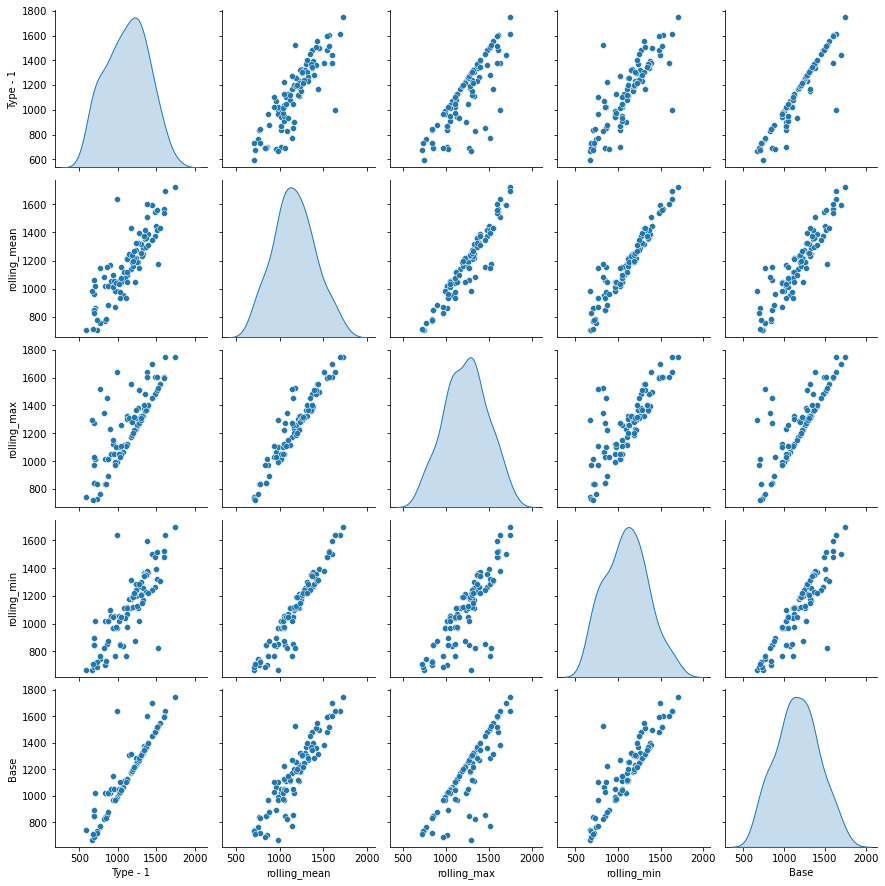

In [33]:
sns.pairplot(retail_model_final, diag_kind = 'kde')

**Inference**: 
All columns are positively correlated now and the data is shown in bell curve shape which means data follows normal distribution according to Empirical rule.

In [34]:
retail_model_final.shape

(98, 5)

## **11. Split data (Train=80%, Test= 20%)**

In [35]:
# Split the time series data (Train-78, Test-20)
#retail_data = retail_data.set_index('StartDate')
print('Total records in dataset:', len(retail_model_final))
retail_train = retail_model_final.iloc[0:78]               
retail_test = retail_model_final.iloc[78:]

retail_pred_train = retail_model_final.iloc[0:78]               
retail_pred_test = retail_model_final.iloc[78:]
print('Total records in Training set:', len(retail_train))
print('Total records in Test set:', len(retail_test))

Total records in dataset: 98
Total records in Training set: 78
Total records in Test set: 20


## **12. Plot Train and Test data**

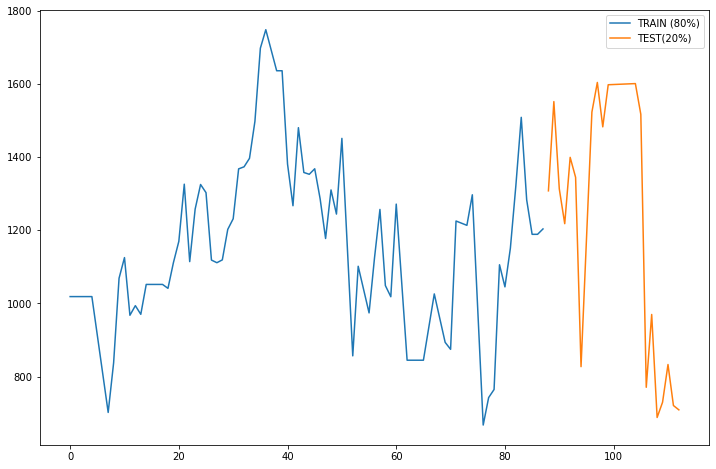

In [36]:
retail_train['Base'].plot(legend=True,label='TRAIN (80%)')
retail_test['Base'].plot(legend=True,label='TEST(20%)',figsize=(12,8));

In [37]:
X_train = retail_train.drop(['Base'], axis=1)
y_train = retail_train['Base'].values

X_test = retail_test.drop(['Base'], axis=1)
y_test = retail_test['Base'].values

In [38]:
X_pred_train = retail_pred_train.drop(['Base'], axis=1)
y_pred_train = retail_pred_train['Base'].values

X_pred_test = retail_pred_test.drop(['Base'], axis=1)
y_pred_test = retail_pred_test['Base'].values

## **13. Modelling**

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

### **1. Holt Winter**

#### **a. Simple Exponential Smoothing**

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
ses_model = SimpleExpSmoothing(retail_train['Base']).fit(smoothing_level=0.3)
ses_preds = ses_model.forecast(steps = 20) #ses_model.predict(start=retail_test.index[0], end=retail_test.index[len(y_test)-1])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [41]:
ses_errors_df = retail_test[['Base']]
ses_errors_df['Predicted_Base'] = ses_preds
ses_errors_df['Error'] = ses_preds - y_test
ses_errors_df.insert(0, 'Modelname', 'Holtman- SES')
ses_errors_df.head()

,Modelname,Base,Predicted_Base,Error
88,Holtman- SES,1308.240,1214.000638,-384.619362
89,Holtman- SES,1552.500,1214.000638,-387.754362
90,Holtman- SES,1313.465,1214.000638,-303.599362
91,Holtman- SES,1218.390,1214.000638,443.400638
92,Holtman- SES,1399.880,1214.000638,244.120638


In [42]:
#retail_train['Base'].plot(legend=True,label='TRAIN')
#retail_test['Base'].plot(legend=True,label='TEST',figsize=(12,8))
#ses_predict["Forecasted_Base"].plot(legend=True,label='PREDICTIONS')
#plt.title('Forecast using HoltWinter-SES model')

#### **b. Double Exponential Smoothing**

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
double_model = ExponentialSmoothing(retail_train['Base'],trend='add').fit()
doublemodel_preds = double_model.forecast(20).rename('DES Forecast')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [44]:
des_errors_df = retail_test[['Base']]
des_errors_df['Predicted_Base'] = doublemodel_preds
des_errors_df['Error'] = doublemodel_preds - y_test
des_errors_df.insert(0, 'Modelname', 'Holtman- DES')
des_errors_df.head()

,Modelname,Base,Predicted_Base,Error
88,Holtman- DES,1308.240,1207.563665,-391.056335
89,Holtman- DES,1552.500,1207.582416,-394.172584
90,Holtman- DES,1313.465,1207.601166,-309.998834
91,Holtman- DES,1218.390,1207.619917,437.019917
92,Holtman- DES,1399.880,1207.638668,237.758668


#### **c. Triple Exponential**

In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
triple_model = ExponentialSmoothing(retail_train['Base'],trend='add', seasonal= 'mul',seasonal_periods= 12).fit(use_boxcox=False, remove_bias=False)
tes_forecast = triple_model.forecast(20).rename('TES_Forecast')
#triplemodel_preds = pd.Series(triple_model.predict(start=retail_test.index[0], end=retail_test.index[len(y_test-1)]), 
                       #name='Forecast_Sales').reset_index()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [46]:
tes_errors_df = retail_test[['Base']]
tes_errors_df['Predicted_Base'] = tes_forecast
tes_errors_df['Error'] = tes_forecast - y_test
tes_errors_df.insert(0, 'Modelname', 'Holtman- TES')
tes_errors_df.head()

,Modelname,Base,Predicted_Base,Error
88,Holtman- TES,1308.240,1186.217116,-412.402884
89,Holtman- TES,1552.500,1175.970179,-425.784821
90,Holtman- TES,1313.465,902.442791,-615.157209
91,Holtman- TES,1218.390,1066.564826,295.964826
92,Holtman- TES,1399.880,1000.213835,30.333835


#### **d. Plot sales using Holtman Forecast models**

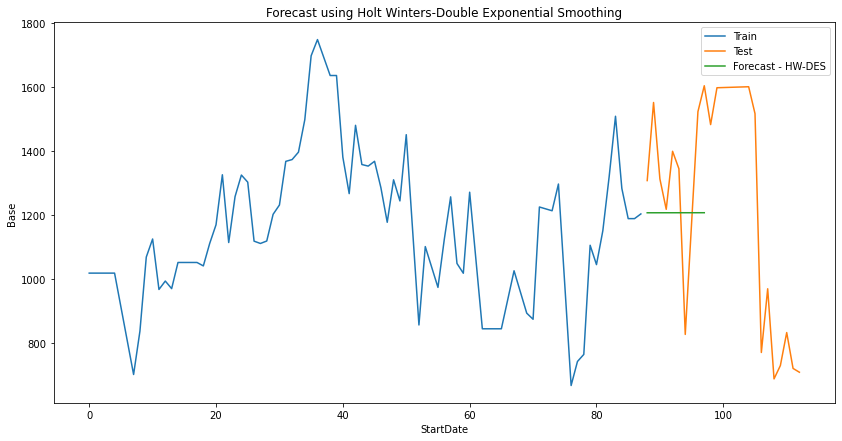

In [47]:
# Evaluate predictions for Holt Winters-Double Exponential Smoothing
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(des_errors_df.index, des_errors_df['Predicted_Base'], label='Forecast - HW-DES')
plt.legend(loc='best')
plt.xlabel('StartDate')
plt.ylabel('Base')
plt.title('Forecast using Holt Winters-Double Exponential Smoothing')
plt.show()

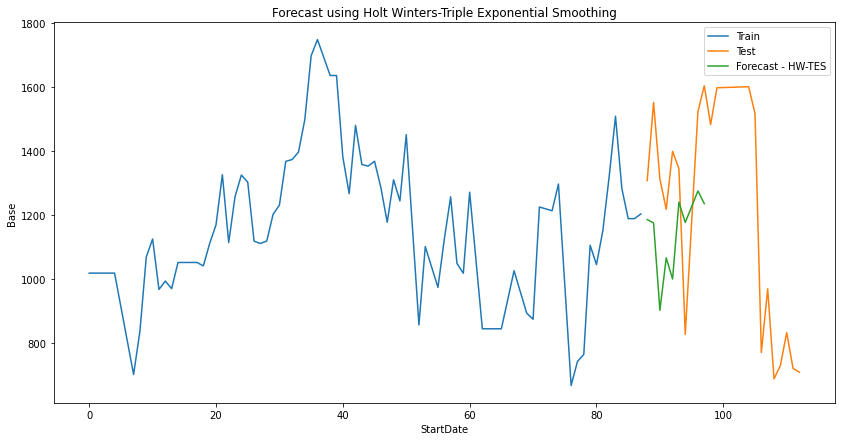

In [48]:
# Evaluate predictions for Holt Winters-Triple Exponential Smoothing
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(tes_errors_df.index, tes_errors_df['Predicted_Base'], label='Forecast - HW-TES')
plt.legend(loc='best')
plt.xlabel('StartDate')
plt.ylabel('Base')
plt.title('Forecast using Holt Winters-Triple Exponential Smoothing')
plt.show()

**Define Metrics**

In [49]:
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=tes_errors_df['Base']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

### **2. Extra Trees Regressor**

In [50]:
# fit model
etr_model = ExtraTreesRegressor(n_estimators=100)
etr_model.fit(X_train, y_train)

ExtraTreesRegressor()

In [51]:
etr_preds = etr_model.predict(X_test)
print('Prediction is done..')

Prediction is done..


#### **a. Calculating Scores for train and test sets**

In [52]:
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

Model Score at Train set: 100.00%
Model Score at Test set: 96.97%


**Errors calculated**

In [53]:
etr_errors_df = retail_test[['Base']]
etr_errors_df['Predicted_Base'] = etr_preds
etr_errors_df['Error'] = etr_preds - y_test
etr_errors_df.insert(0, 'Modelname', 'ExtreeTreesRegressor')
etr_errors_df.head()

,Modelname,Base,Predicted_Base,Error
88,ExtreeTreesRegressor,1308.240,1303.429000,-4.811000
89,ExtreeTreesRegressor,1552.500,1508.530675,-43.969325
90,ExtreeTreesRegressor,1313.465,1314.645125,1.180125
91,ExtreeTreesRegressor,1218.390,1258.938550,40.548550
92,ExtreeTreesRegressor,1399.880,1382.284000,-17.596000


#### **b. Plot sales using Extra Trees Regressor**

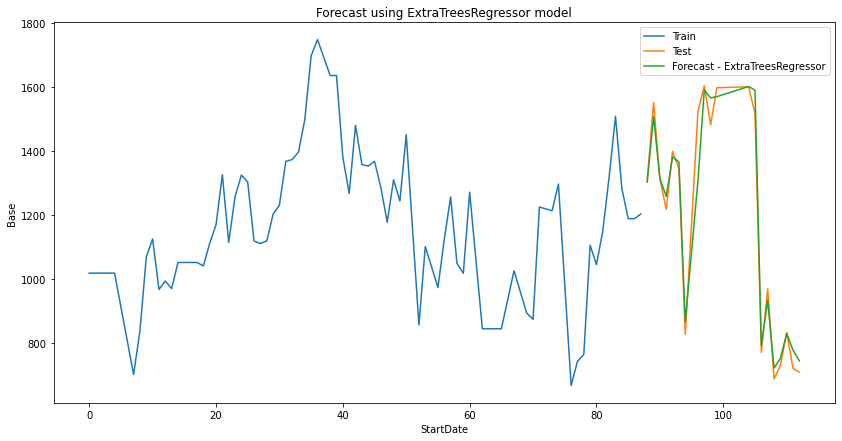

In [54]:
# Evaluate predictions for Extra Tree Regressor
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(etr_errors_df.index, etr_errors_df['Predicted_Base'], label='Forecast - ExtraTreesRegressor')
plt.legend(loc='best')
plt.xlabel('StartDate')
plt.ylabel('Base')
plt.title('Forecast using ExtraTreesRegressor model')
plt.show()

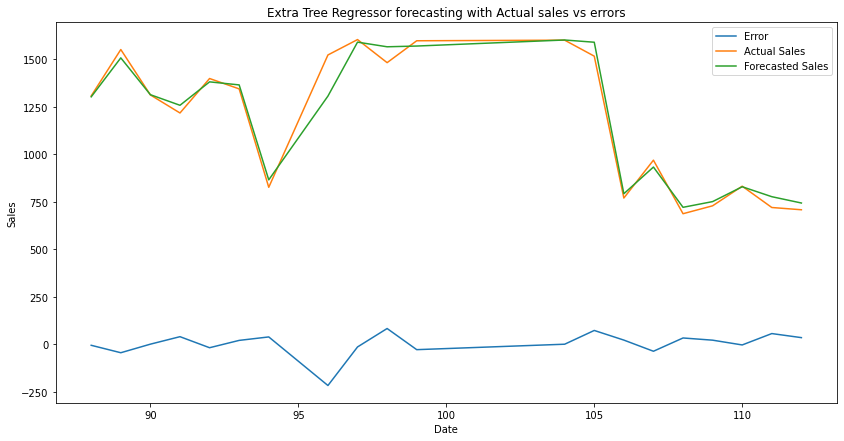

In [55]:
fig = plt.figure(figsize=(14,7))
plt.plot(etr_errors_df.index, etr_errors_df.Error, label='Error')
plt.plot(etr_errors_df.index, etr_errors_df.Base, label='Actual Sales')
plt.plot(etr_errors_df.index, etr_errors_df.Predicted_Base, label='Forecasted Sales')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Extra Tree Regressor forecasting with Actual sales vs errors')
plt.show()

### **3. Linear Regression**

In [56]:
# fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [57]:
lr_preds = lr_model.predict(X_test)
print('Prediction is done..')

Prediction is done..


**Errors calculated**

In [58]:
lr_errors_df = retail_test[['Base']]
lr_errors_df['Predicted_Base'] = lr_preds
lr_errors_df['Error'] = lr_preds - y_test
lr_errors_df.insert(0, 'Modelname', 'Linear Regression')
lr_errors_df.head()

,Modelname,Base,Predicted_Base,Error
88,Linear Regression,1308.240,1301.845307,-6.394693
89,Linear Regression,1552.500,1478.518191,-73.981809
90,Linear Regression,1313.465,1321.434309,7.969309
91,Linear Regression,1218.390,1272.829307,54.439307
92,Linear Regression,1399.880,1356.579307,-43.300693


#### **Plot sales using Linear Regression**

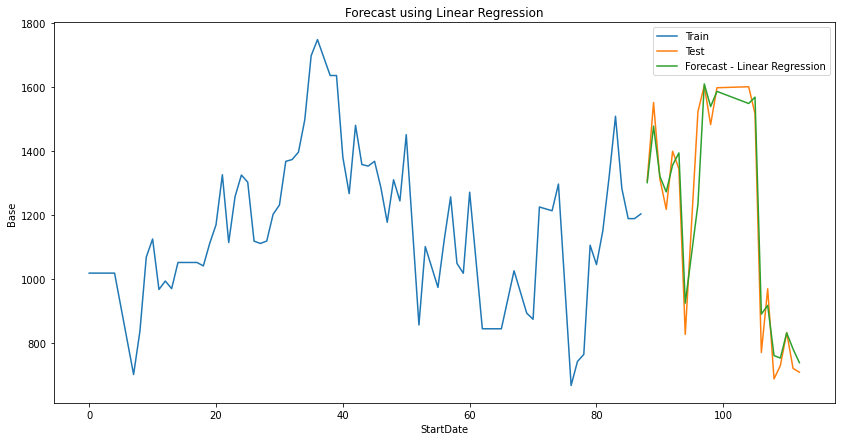

In [59]:
# Evaluate predictions for Linear Regression
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(lr_errors_df.index, lr_errors_df['Predicted_Base'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('StartDate')
plt.ylabel('Base')
plt.title('Forecast using Linear Regression')
plt.show()

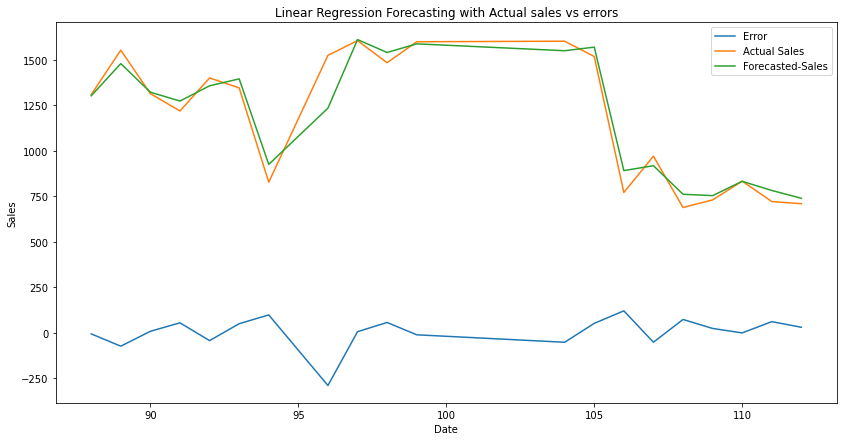

In [60]:
fig = plt.figure(figsize=(14,7))
plt.plot(lr_errors_df.index, lr_errors_df.Error, label='Error')
plt.plot(lr_errors_df.index, lr_errors_df.Base, label='Actual Sales')
plt.plot(lr_errors_df.index, lr_errors_df.Predicted_Base, label='Forecasted-Sales')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Linear Regression Forecasting with Actual sales vs errors')
plt.show()

### **4. ARIMA/SARIMA**

In [61]:
arima_model = ARIMA(retail_model_final.Base, (6,1,1)).fit(disp=False)
print(arima_model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Base   No. Observations:                   97
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -645.209
Method:                       css-mle   S.D. of innovations            186.970
Date:                Thu, 11 Feb 2021   AIC                           1308.418
Time:                        15:13:32   BIC                           1331.590
Sample:                             1   HQIC                          1317.788
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.1043      8.643     -0.243      0.808     -19.044      14.835
ar.L1.D.Base     0.0637      0.459      0.139      0.890      -0.836       0.964
ar.L2.D.Base    -0.0489      0.181     -0.27

In [62]:
# fit the model
sarima_model = SARIMAX(retail_model_final.Base, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
sarima_test_df = retail_test[["Base"]]
sarima_test_df['Predicted_Base'] = sarima_fit.predict(start=retail_test.index[0],
                                                 end=retail_test.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1008x504 with 0 Axes>

In [64]:
# Evaluation
sarima_test_df['Error'] = sarima_test_df.Base - sarima_test_df.Predicted_Base
sarima_test_df.insert(0, 'Modelname', 'SARIMA')
sarima_test_df.head()

,Modelname,Base,Predicted_Base,Error
88,SARIMA,1308.240,1586.801252,-278.561252
89,SARIMA,1552.500,1511.061971,41.438029
90,SARIMA,1313.465,1343.741565,-30.276565
91,SARIMA,1218.390,1085.284089,133.105911
92,SARIMA,1399.880,1105.313305,294.566695


#### **Plot sales using SARIMA model**

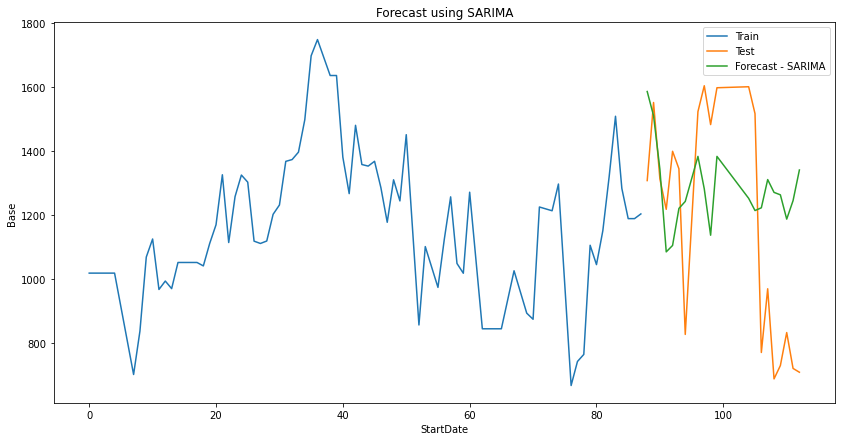

In [65]:
# Evaluate the predictions for Seasonal ARIMA model
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Base'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('StartDate')
plt.ylabel('Base')
plt.title('Forecast using SARIMA')
plt.show()

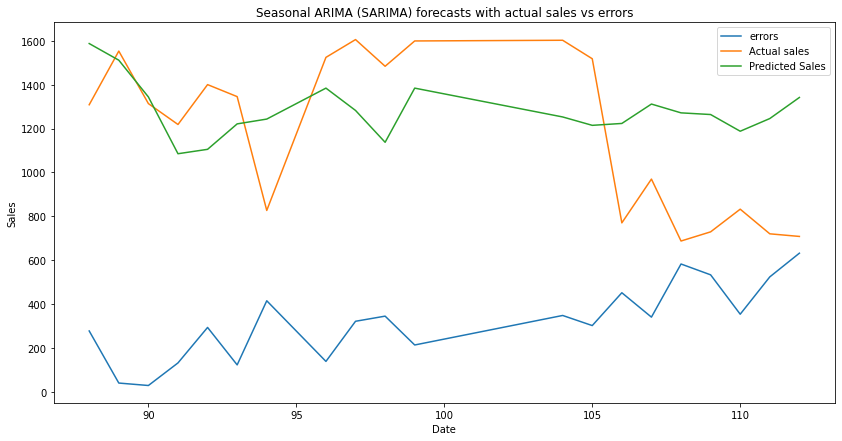

In [66]:
plt.figure(figsize=(14,7))
plt.plot(sarima_test_df.index, np.abs(sarima_test_df['Error']), label='errors')
plt.plot(sarima_test_df.index, sarima_test_df['Base'], label='Actual sales')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Base'], label='Predicted Sales')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales vs errors')
plt.show()

### **5. Multiple Linear Regression**

In [67]:
import statsmodels.api as sm

# Note the difference in argument order
ml_model = sm.OLS(retail_model_final.Base, retail_model_final.drop(columns= ["Base"])).fit() ## sm.OLS(output, input)
ml_preds = ml_model.predict(X_test)

# Print out the statistics
ml_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Base   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.083e+04
Date:                Thu, 11 Feb 2021   Prob (F-statistic):                   2.99e-120
Time:                        15:14:07   Log-Likelihood:                         -547.05
No. Observations:                  98   AIC:                                      1100.
Df Residuals:                      95   BIC:                                      1108.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Type - 1         0.5265      0.048     10.994      0.000       0.431       0.622
rolling_mean     0.1693      0.016     10.795      0.000       0.138       0.200
rolling_max      0.0190      0.043      0.438      0.662      -0.067       0.105
rolling_min      0.3196      0.049      6.554      0.000       0.223       0.416
==============================================================================
Omnibus:                       39.517   Durbin-Watson:                   2.390
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.047
Skew:                           1.526   Prob(JB):                     2.80e-20
Kurtosis:                       6.569   Cond. No.                     6.89e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.15e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [68]:
ml_preds

88     1311.111484
89     1507.183036
90     1307.417338
91     1270.173532
92     1374.686961
93     1397.190802
94      909.218724
96     1294.614805
97     1627.370812
98     1547.022476
99     1607.050555
104    1536.542431
105    1578.550102
106     874.513918
107     922.695489
108     740.864191
109     737.928655
110     826.156834
111     764.600047
112     715.404662
dtype: float64

In [69]:
ml_errors_df = retail_test[['Base']]
ml_errors_df['Predicted_Base'] = ml_preds
ml_errors_df['Error'] = ml_preds - y_test
ml_errors_df.insert(0, 'Modelname', 'Multi Linear Regression')
ml_errors_df.head()

,Modelname,Base,Predicted_Base,Error
88,Multi Linear Regression,1308.240,1311.111484,2.871484
89,Multi Linear Regression,1552.500,1507.183036,-45.316964
90,Multi Linear Regression,1313.465,1307.417338,-6.047662
91,Multi Linear Regression,1218.390,1270.173532,51.783532
92,Multi Linear Regression,1399.880,1374.686961,-25.193039


#### **Plot forecast sales using MLR model**

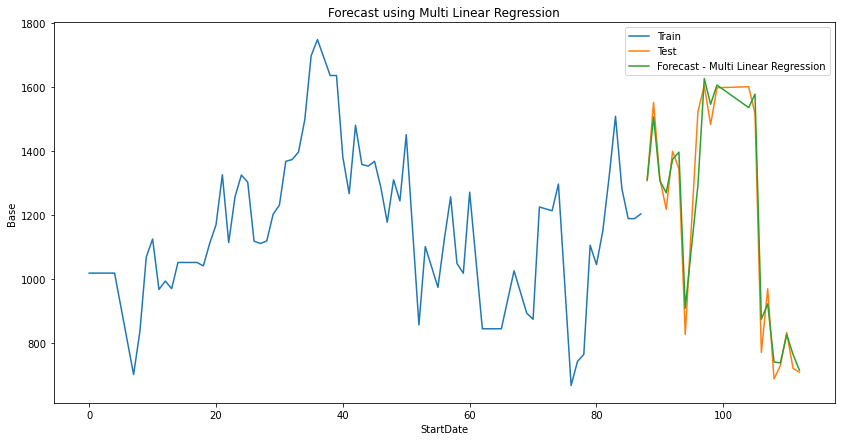

In [70]:
# Evaluate predictions for Linear Regression
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(ml_errors_df.index, ml_errors_df['Predicted_Base'], label='Forecast - Multi Linear Regression')
plt.legend(loc='best')
plt.xlabel('StartDate')
plt.ylabel('Base')
plt.title('Forecast using Multi Linear Regression')
plt.show()

### **6. KNNRegressor**

In [71]:
import sklearn
svr_model = sklearn.svm.SVR(kernel='linear', degree=3, C=1.0,).fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
print('Prediction is done...')
# Errors calculation
svr_errors_df = retail_test[['Base']]
svr_errors_df['Predicted_Base'] = svr_preds
svr_errors_df['Error'] = svr_preds - y_test
svr_errors_df.insert(0, 'Modelname', 'Support Vector Regressor')
svr_errors_df.head()

Prediction is done...


,Modelname,Base,Predicted_Base,Error
88,Support Vector Regressor,1308.240,1301.343860,-6.896140
89,Support Vector Regressor,1552.500,1511.415653,-41.084347
90,Support Vector Regressor,1313.465,1270.454983,-43.010017
91,Support Vector Regressor,1218.390,1247.887624,29.497624
92,Support Vector Regressor,1399.880,1376.072569,-23.807431


#### **Plot forecast sales using SVR model**

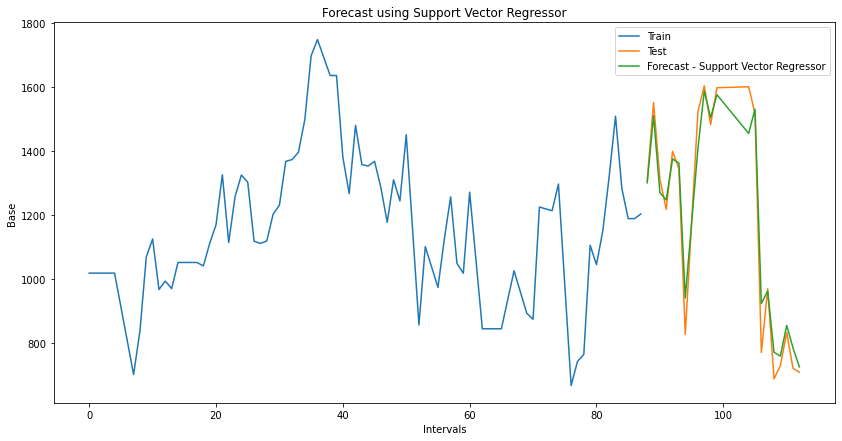

In [72]:
# Evaluate predictions for Support Vector Regressor
fig = plt.figure(figsize=(14,7))
plt.plot(retail_train.index, retail_train['Base'], label='Train')
plt.plot(retail_test.index, retail_test['Base'], label='Test')
plt.plot(svr_errors_df.index, svr_errors_df['Predicted_Base'], label='Forecast - Support Vector Regressor')
plt.legend(loc='best')
plt.xlabel('Intervals')
plt.ylabel('Base')
plt.title('Forecast using Support Vector Regressor')
plt.show()

## **14. Calculate Metrics (MAE/RMSE/MAPE)**

In [73]:
result_df_svr = svr_errors_df.groupby('Modelname').agg(Total_Sales=('Base', 'sum'),
                                          Total_Pred_Sales=('Predicted_Base', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_svr

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Support Vector Regressor,23715.465,23859.879844,144.414844,49.331032,67.238933,4.160242


In [74]:
result_df_sarima = sarima_test_df.groupby('Modelname').agg(Total_Sales=('Base', 'sum'),
                                          Total_Pred_Sales=('Predicted_Base', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_sarima

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
SARIMA,23715.465,25595.066976,-1879.601976,320.848434,362.256666,27.058161


In [75]:
result_df_hw = tes_errors_df.groupby('Modelname').agg(Total_Sales=('Base', 'sum'),
                                          Total_Pred_Sales=('Predicted_Base', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_hw

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Holtman- TES,23715.465,10261.744931,956.104931,429.199418,460.774739,16.288084


In [76]:
result_df_lr = lr_errors_df.groupby('Modelname').agg(Total_Sales=('Base', 'sum'),
                                          Total_Pred_Sales=('Predicted_Base', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_lr

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Linear Regression,23715.465,23815.65636,100.19136,58.065125,84.520432,4.896815


In [77]:
result_df_etr = etr_errors_df.groupby('Modelname').agg(Total_Sales=('Base', 'sum'),
                                          Total_Pred_Sales=('Predicted_Base', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_etr

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
ExtreeTreesRegressor,23715.465,23782.807525,67.342525,39.699729,60.845556,3.348003


In [78]:
result_df_mlr = ml_errors_df.groupby('Modelname').agg(Total_Sales=('Base', 'sum'),
                                          Total_Pred_Sales=('Predicted_Base', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_mlr

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Multi Linear Regression,23715.465,23850.296854,134.831854,49.237903,69.971433,4.152388


## **15. Table of Metrics for model comparision**

In [79]:
list_objs = [result_df_etr, result_df_mlr, result_df_svr, result_df_lr, result_df_hw, result_df_sarima]
metrics_table = pd.concat(list_objs)
metrics_table

,Total_Sales,Total_Pred_Sales,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
ExtreeTreesRegressor,23715.465,23782.807525,67.342525,39.699729,60.845556,3.348003
Multi Linear Regression,23715.465,23850.296854,134.831854,49.237903,69.971433,4.152388
Support Vector Regressor,23715.465,23859.879844,144.414844,49.331032,67.238933,4.160242
Linear Regression,23715.465,23815.656360,100.191360,58.065125,84.520432,4.896815
Holtman- TES,23715.465,10261.744931,956.104931,429.199418,460.774739,16.288084
SARIMA,23715.465,25595.066976,-1879.601976,320.848434,362.256666,27.058161


In [80]:
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

Model Score at Train set: 100.00%
Model Score at Test set: 96.97%


**Inference**: From above metrics it was clear that "**Extra Trees Regressor**" model performs well out of all 6 models. In addition model score is pretty accurate with (**100%** for Train data, **96.91**% for Test data). Hence, finalizing the model for predicting retail sales and obtaining results in CSV file.

## **16. Submission file with Prediction values**

In [81]:
# Create submission dataframe
submission_etr_df = pd.DataFrame(data=etr_preds, columns=['Predicted_Base'])
submission_etr_df.head()



,Predicted_Base
0,1303.429000
1,1508.530675
2,1314.645125
3,1258.938550
4,1382.284000


In [82]:
retail_pred_test.head()

,Type - 1,rolling_mean,rolling_max,rolling_min,Base
88,1308.24,1256.1050,1308.240,1203.970,1308.240
89,1552.50,1430.3700,1552.500,1308.240,1552.500
90,1169.09,1432.9825,1552.500,1313.465,1313.465
91,1218.39,1265.9275,1313.465,1218.390,1218.390
92,1399.88,1309.1350,1399.880,1218.390,1399.880


In [83]:
retail_pred_test.drop(columns= ['Type - 1','rolling_mean','rolling_max','rolling_min'], inplace=True)
retail_pred_test.head()

,Base
88,1308.240
89,1552.500
90,1313.465
91,1218.390
92,1399.880


In [84]:
# Reset index 
retail_pred_test.reset_index(inplace=True)
retail_pred_test.head()

,index,Base
0,88,1308.240
1,89,1552.500
2,90,1313.465
3,91,1218.390
4,92,1399.880


In [85]:
retail_pred_test = retail_pred_test.drop(columns=["index"])
submission_results = pd.merge(retail_pred_test, submission_etr_df, left_index=True, right_index=True)
submission_results.head()

,Base,Predicted_Base
0,1308.240,1303.429000
1,1552.500,1508.530675
2,1313.465,1314.645125
3,1218.390,1258.938550
4,1399.880,1382.284000


In [87]:
## Saving file to csv
submission_results.to_csv('/kaggle/working/ETR_predictions.csv', index= False)
print('CSV file loaded with results in the path: /content/drive/My Drive/retail_forecast/')

CSV file loaded with results in the path: /content/drive/My Drive/retail_forecast/
